In [1]:
import numpy as np
from scipy import integrate    
import matplotlib.pyplot as plt
import itertools
import arviz as az
import seaborn as sns
import pandas as pd
import pickle
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2g}'.format)

from rsindy_bayes import *

### Model
$$
\begin{align*}
    g + P_2 &\overset{k_1}{\to} gP_2 \\
    gP_2 &\overset{k_2}{\to} g + P_2 \\
    g &\overset{k_3}{\to} g + r \\
    r &\overset{k_4}{\to} r + P \\
    2P &\overset{k_5}{\to} P_2 \\
    P_2 &\overset{k_6}{\to} 2P \\
    r &\overset{k_7}{\to} \phi \\
    P &\overset{k_8}{\to} \phi 
\end{align*}
$$

which can be translated into

$$
\begin{align*}
    \frac{dg}{dt} &= k_2 gP2 - k_1 g P_2 \\
    \frac{dP_2}{dt} &= k_5 P^2 + k_2 gP2 - k_1 g P_2 - k_6 P_2\\
    \frac{dgP2}{dt} &= k_1 g P_2 - k_2 gP2 \\
    \frac{dr}{dt} &= k_3 g - k_7 r\\
    \frac{dP}{dt} &= k_4 r + 2 k_6 P_2 - 2 k_5 P^2 - k_8P\\
\end{align*}
$$

In [2]:
def simulate_data(theta, t):
    
    Z0 = [20, 20, 20, 20, 20]
    k1, k2, k3, k4, k5, k6, k7, k8 = theta
    def dZdt(Z, t = 0):
        g, p2, gp2, r, p = Z
        
        dgdt = k2 * gp2 - k1 * g * p2
        dp2dt = k5 * p * p + k2 * gp2 - k1 * g * p2 - k6 * p2
        dgp2dt = k1 * g * p2 - k2 * gp2
        drdt = k3 * g - k7 * r
        dpdt = k4 * r + 2 * k6 * p2 - 2 * k5 * p * p - k8 * p
        
    
        return [dgdt, dp2dt, dgp2dt, drdt, dpdt]
    
    Z_obs = integrate.odeint(dZdt, Z0, t)
    Z_obs_noisy = Z_obs.copy()
    Z_obs_noisy[1:,:] = np.exp(np.log(Z_obs_noisy[1:,:]) + np.random.normal(0, 0.07, size = Z_obs_noisy[1:,:].shape))

    return Z_obs, Z_obs_noisy

In [20]:
Strue = [[-1, -1,  1,  0,  0,  0],
         [ 1,  1, -1,  0,  0,  0],
         [ 0,  0,  0,  1,  0,  0],
         [ 0,  0,  0,  0,  1,  0],
         [ 0,  1,  0,  0, -2,  0],
         [ 0, -1,  0,  0,  2,  0],
         [ 0,  0,  0, -1,  0,  0],
         [ 0,  0,  0,  0, -1,  0]
]
Strue = np.array(Strue)
Rtrue = [[1,  1,  0,  0,  0,  0],
         [0,  0,  1,  0,  0,  0],
         [1,  0,  0,  0,  0,  0],
         [0,  0,  0,  1,  0,  0],
         [0,  0,  0,  0,  2,  0],
         [0,  1,  0,  0,  0,  0],
         [0,  0,  0,  1,  0,  0],
         [0,  0,  0,  0,  1,  0]
]
Rtrue = np.array(Rtrue)
theta = np.array([1, 2, 0.3, 2., 1, 1, 3, 0.3])
theta = theta/2
species_names = ['g', 'p_2', 'g.p_2', 'r', 'p']

### Observations

In [ ]:
t = np.arange(0, 1, 0.04)
Z_obs, Z_obs_noisy = simulate_data(theta, t)

In [4]:
obs = pickle.load(open("results/argn/obs_0.07.p", "rb"))
t = obs["t"]
Z_obs_noisy = obs["Z_obs_noisy"]

In [ ]:
obs = {"t" : t,
       "Z_obs" : Z_obs, 
       "Z_obs_noisy" : Z_obs_noisy}
pickle.dump(obs, open("results/argn/obs_0.07.p", "wb"))

In [ ]:
fig, ax = plt.subplots(5, 1, sharex=True)
for i in range(5):
    ax[i].plot(t, Z_obs[:,i], color = 'C0', label = 'True')
    ax[i].plot(t, Z_obs_noisy[:,i], 'x', color = 'C1', label = 'Noisy Observations')
    ax[i].legend()
    ax[i].set_title(species_names[i])
    ax[i].set_ylabel("Concentration")
    ax[i].set_ylim([0, None])
ax[4].set_xlabel("Time")
fig.set_size_inches(10, 20)
#plt.savefig("figures/argn_obs.png", dpi = 600)

## Non-Regularized Bayesian Linear Regression

In [ ]:
bs_nonregularized = RSINDyNonRegularized(species_names)

In [ ]:
fit, reordered, S,R, D  = bs_nonregularized.fit_dx(
                                                Z_obs,
                                                 t,
                                                 known_S = Strue,
                                                 known_R = Rtrue,
                                                 known_rates = [],
                                                 N = 265 - 8,
                                                 model_params = {
                                                    'noise_sigma' : 1
                                                 },
                                                 fit_params = {
                                                    'chains' : 1,
                                                    'show_progress' : 'notebook',
                                                     'variational' : False
                                                 },
                                                 seed = 30
                                               )

In [ ]:
df = fit.summary(sig_figs=5)

In [ ]:
df[df.index.str.contains('^rate')]

## Regularized Horseshoe Bayesian Linear Regression

In [21]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names)

In [28]:
fit_horseshoe_dx, _, S_dx, R_dx, D_dx = bs_horseshoe.fit_dx(
                                                     Z_obs_noisy,
                                                     t,
                                                     known_S = Strue,
                                                     known_R = Rtrue,
                                                     known_rates = theta[:5],
                                                     N = 265 - 8,
                                                     model_params = {
                                                        'm0' : 3,
                                                        'slab_scale' : 1,
                                                        'slab_df' : 4,
                                                        'sigma' : 1,
                                                        'noise_sigma' : 1
                                                     },
                                                     fit_params = {
                                                        'chains' : 1,
                                                        'iter_warmup' : 1,
                                                         'iter_sampling' : 1,
                                                        'show_progress' : 'notebook',
                                                         'variational' : False
                                                     },
                                                     seed = 30
                                                    )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/horseshoe_normal_fixed_dx


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
D_dx

['g + p_2 -> g.p_2',
 'g.p_2 -> g + p_2',
 'g -> g + r',
 'r -> r + p',
 '2p -> p_2',
 'p_2 -> 2p',
 'r -> 0',
 'p -> 0',
 'g.p_2 + p -> p_2 + r',
 'p_2 -> r + p',
 '2g.p_2 -> p_2',
 'g + r -> p_2',
 'r -> p',
 'g + g.p_2 -> 2g.p_2',
 'g.p_2 -> g',
 'g -> 2p',
 'p -> 2g.p_2']

## No-DX

In [5]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names)

In [6]:
fit_horseshoe_ndx, _, S_ndx, R_ndx, D_ndx = bs_horseshoe.fit_non_dx(
                                    Z_obs_noisy, 
                                    t,
                                    known_S = Strue,
                                    known_R = Rtrue,
                                    known_rates = theta[:4],
                                    N = 265 - 8,
                                    model_params = {
                                       'm0' : 4,
                                       'slab_scale' : 1,
                                       'slab_df' : 2,
                                       'sigma' : 0.0001,
                                       'noise_sigma' : 0.07
                                    },
                                    fit_params = {
                                       'chains' : 4,
                                        'iter_warmup' : 3000,
                                        'iter_sampling' : 500,
                                        'show_progress' : 'notebook',
                                        'max_treedepth' : 8,
                                        'init' : None,
                                        'variational' : False
                                    },
                                    seed = 30)   


INFO:cmdstanpy:compiling stan program, exe file: /home/rmjiang/Other/bio_sindy/models/tempfile
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/tempfile


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
#fit_horseshoe_ndx.save_csvfiles("/home/rmjiang/Other/bio_sindy/results/argn")
full_fit = {"fit": fit_horseshoe_ndx, 
        "S" : S_ndx, 
        "R" : R_ndx, 
        "D" : D_dx
       }
pickle.dump(full_fit, open("results/argn/horseshoe_ndx_{:.2f}.p".format(0.07), "wb"))

In [25]:
for i in range(fit_horseshoe_ndx.chains):
    print("%d : %f" % (i, np.mean(fit_horseshoe_ndx.sampler_variables()['lp__'][:,i])))

0 : -903.874552
1 : -901.338380
2 : -950.836034
3 : -933.132474


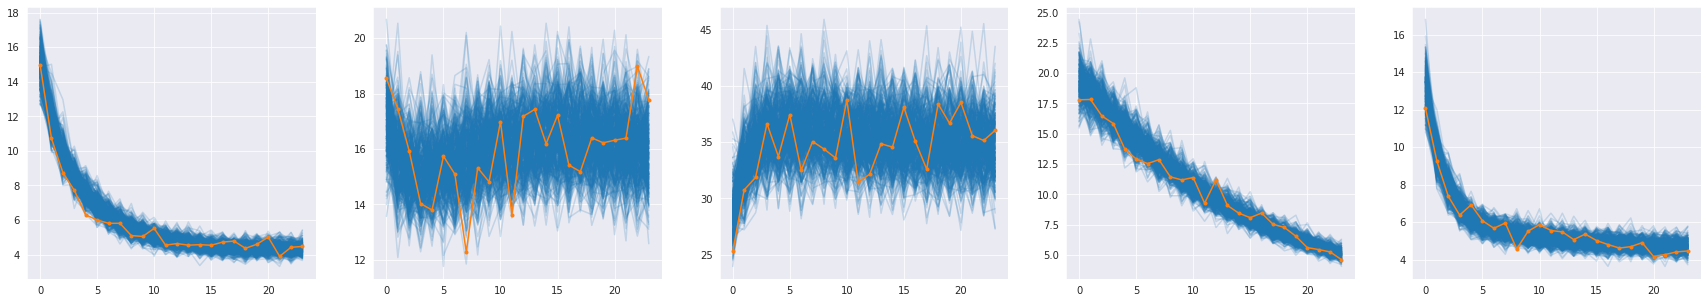

In [26]:
yhat = fit_horseshoe_ndx.stan_variables()['y_rep']
fig, ax = plt.subplots(1,5)
for i in range(400):
    for j in range(5):
        ax[j].plot(yhat[i,:,j], alpha = 0.2, color = 'C0')

for j in range(5):
    ax[j].plot(Z_obs_noisy[1:,j], '.-', color = 'C1')    
fig.set_size_inches(30, 5)

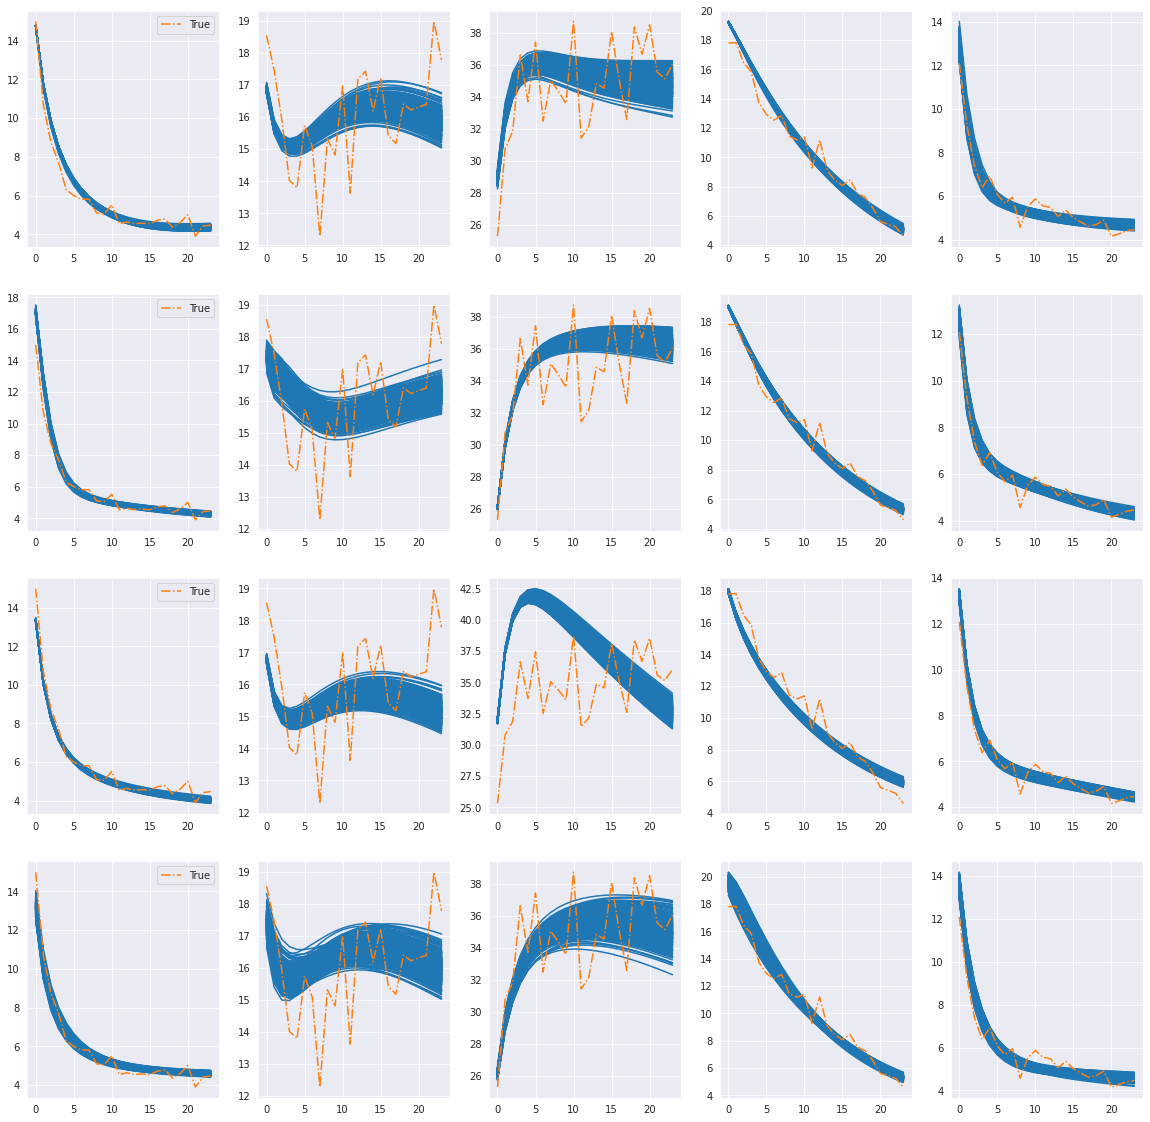

In [14]:
fig, ax = plt.subplots(4,5)
samples = fit_horseshoe_ndx.stan_variables()['y_hat']
for j in range(4):
    for i in range(j * 500,(j + 1) * 500):
        for k in range(5):
            ax[j][k].plot(samples[i, :, k], color = 'C0', alpha = 1);

    for k in range(5):
        ax[j][k].plot(Z_obs_noisy[1:,k], '-.', label = 'True', color = 'C1')
    ax[j][0].legend()
        
fig.set_size_inches(20, 20)

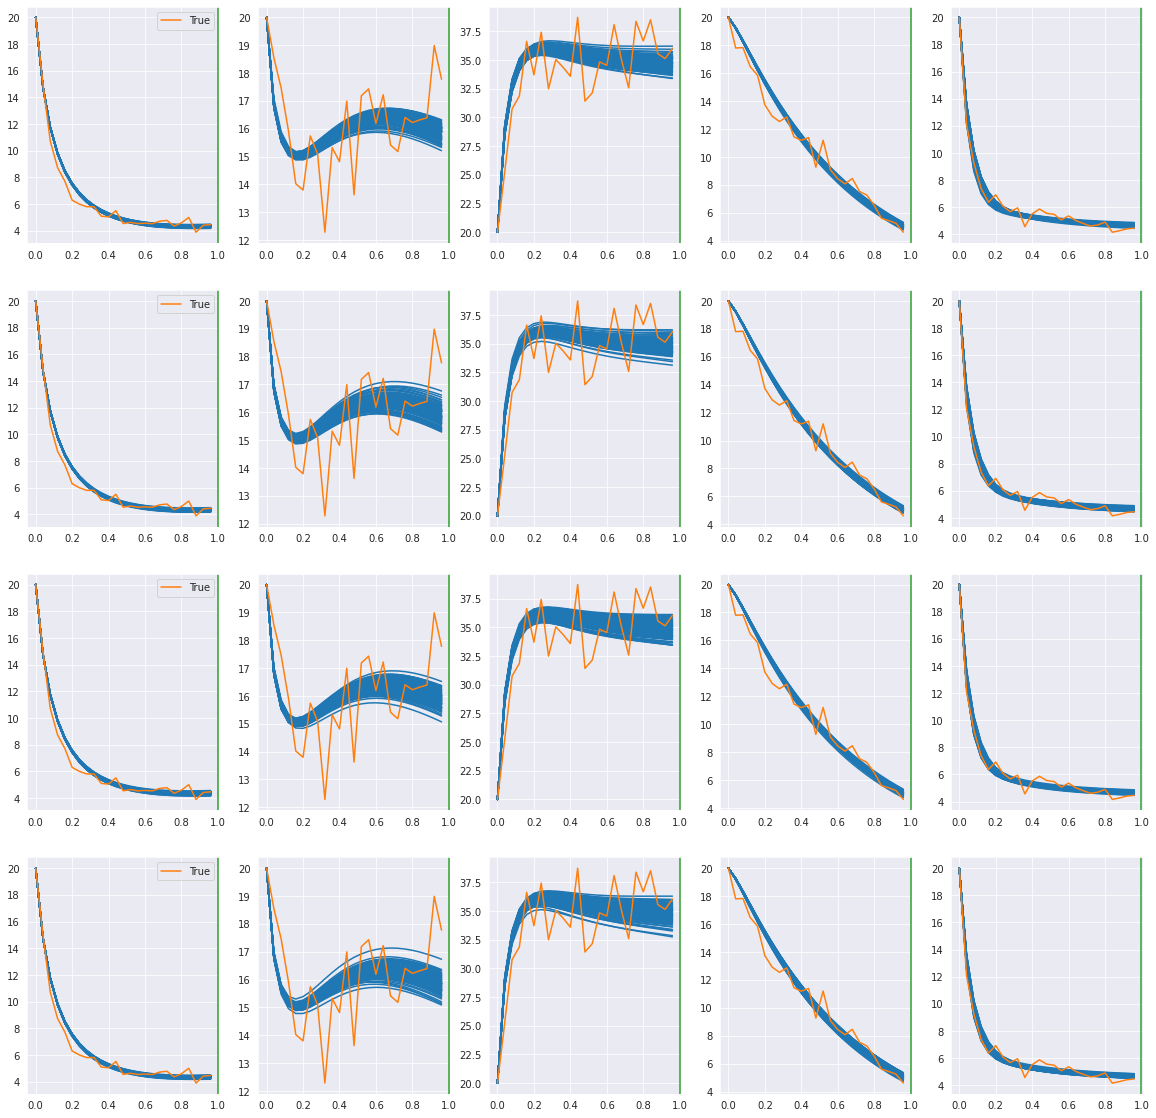

In [10]:
fig, ax = plt.subplots(4,5)
n_nonzero = []
n_nonzero_idx = []
n_nonzero_D = []
samples = fit_horseshoe_ndx.stan_variables()['rates']
for j in range(4):
    n_nonzero_chain = []
    n_nonzero_chain_D =  []
    n_nonzero_chain_idx = []
    for i in range(j * 100,(j + 1) * 100):#samples.shape[0]):
        inferred_rates = samples[i,:]
        inferred_rates[inferred_rates < 1e-3] = 0
        n_nonzero_chain.append(np.sum(inferred_rates != 0))
        n_nonzero_chain_idx.append(np.argwhere(inferred_rates != 0)[:,0])
        n_nonzero_chain_D.append([D_ndx[k] for k in np.argwhere(inferred_rates != 0)[:,0]])
        def dZdt_inf(Z, t = 0):

            ap = np.hstack([Z, 1]) * (R_ndx == 1)
            ap += (np.hstack([Z, 1]) * (R_ndx == 2)) ** 2
            ap_mask = ap + (ap == 0).astype(np.float32)
            extend_Z = np.prod(ap_mask, axis = 1) * inferred_rates
            return (S_ndx.T @ extend_Z)[:-1]
        Z_obs_inf = integrate.odeint(dZdt_inf, [20, 20, 20, 20, 20], t)
        for k in range(5):
            ax[j][k].plot(t, Z_obs_inf[:, k], color = 'C0', alpha = 1);

    for k in range(5):
        ax[j][k].plot(t, Z_obs_noisy[:,k], label = 'True', color = 'C1')
        ax[j][k].axvline(1, color = 'C2')
    ax[j][0].legend()
    n_nonzero.append(n_nonzero_chain)
    n_nonzero_D.append(n_nonzero_chain_D)
    n_nonzero_idx.append(n_nonzero_chain_idx)
        
fig.set_size_inches(20, 20)